## Exercise 1
## Sun only simulation

In [1]:
%reload_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt

import h5py

# Module to generate initial conditions as .hdf5 file
from main.make_ics import generate_ics

# Module to integrate orbits on a NFW potential
from main.nfw import Simulation

# Module to generate plots
import main.plot_utils as pu

### Generation of initial conditions
We start by generating an initial conditions (ICs) file for a single body (the Sun). The code here for generating the ICs and simulating is overkill for a single body, but generalizes to N-bodies

In [2]:
POS = np.array([[8,0,0]], dtype=np.float32)
VEL = np.array([[0,127,0]], dtype=np.float32)
MASS = np.array([1], dtype=np.float32)

sim_folder = 'results/sun_only/'  # Folder to save the results
path_ics = f'{sim_folder}ics.hdf5'  # Path to save the initial conditions

generate_ics(path_ics, POS, VEL, MASS)

## Integrating the Orbit

We integrate the orbit by means of the `Simulation` class. We choose the integration scheme by means of the `.set_integrator()` method. What follows is the integration of the Sun orbit using the Euler method and RK4. 

Most of the runtime delay comes from writting the data for snapshots in the `output.hdf5` file, which we are not using it now, as we get the data straight from the `Simulation`class. 

Everything is optimized by using the `numba` package and its `@jit` (Just in Time) complier in no python mode. This really makes a difference for large number of bodies, specially it is also set in pparallel mode.  

The update of positions is handled when the method `Simulation.run_simulation()`, which relies on the `net_fields()` auxilliary function defined in the `nfw.py` module, which computes the acceleration due to the NFW DM halo; and the `rk4_step()` or `euler_step()` functions for position updates (also defined in  `nfw.py`)

In [3]:
## Integration using Euler method

T = 2  # Time of integration
NT = 1000  # Number of time steps
num_snapshots = 500  # Number of snapshots to save

path_output = sim_folder + 'output_euler.hdf5'
Sim = Simulation(path_ics, path_output)

dt = T/NT
Sim.set_time(T, dt, snapshots=num_snapshots)

Sim.set_integrator('euler')
Sim.run_simulation()
POS_E, VEL_E, MASS, TIME = Sim.get_output()

99.90%
Elapsed time: 3.18 s


In [4]:
## Integration using RK4 method

T = 2  # Time of integration
NT = 1000  # Number of time steps
num_snapshots = 500  # Number of snapshots to save

path_output = sim_folder + 'output_RK4.hdf5'
Sim = Simulation(path_ics, path_output)

dt = T/NT
Sim.set_time(T, dt, snapshots=num_snapshots)

Sim.set_integrator('RK4')
Sim.run_simulation()
POS_R, VEL_R, MASS, TIME = Sim.get_output()

99.90%
Elapsed time: 3.26 s


## Plotting the orbits

We observe that using the Euler integration the orbit of the Sun is not preserved, as it grows radially, spiraling outwards. This is expected as Euler integration is a first-order method, meaning the error per step is proportional to the step size. This cumulative error is what leads to non-physical results.

In contrast, the Runge-Kutta 4 (RK4) method is a fourth-order scheme, with errors scaling with the fourth power of the step size. RK4 achieves better accuracy by averaging the increments, which leads to an accurate, bounded, and stable orbit.

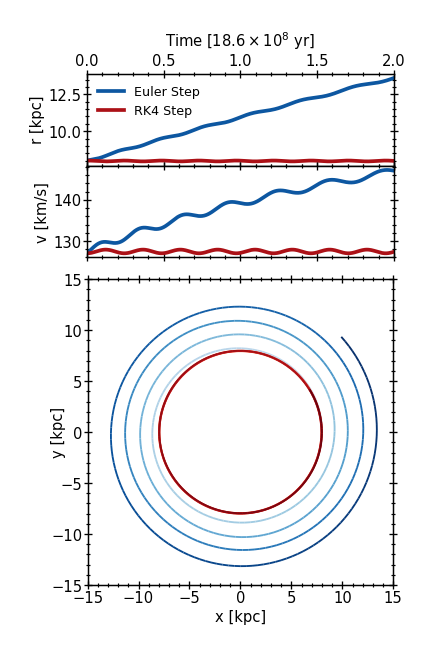

In [5]:
savepath = 'figures/ex1_sun_only_euler_RK4.jpg'

pu.plot_euler_rk4_orbits(POS_E, VEL_E, POS_R, VEL_R, TIME, savepath=savepath)